In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel, BertConfig
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

C:\Users\USER\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Init

In [74]:
device = "cuda" if torch.cuda.is_available() else "cpu"
configuration = BertConfig()
bert_model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True).to(device)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
args = {
        "device" : device,
        "data_dir" : r'../data/filtered_reviews_with_split.pkl',
        "data_chunks_dir" : r'../data/chunks',
        "emb_dim" : 768,
        "max_word" : 25,
        "max_sentence" : 10,
        "max_group": 5, # exclude default group
        "max_review_user" : 20,
        "max_review_item" : 50,
        "epoch" : 5,
        "batch_size": 32,
        "bert_configuration" : configuration,
        "bert_model" : bert_model,
        "bert_tokenizer" : bert_tokenizer
    }

print("Device: ",device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Device:  cuda


## Read Pickle

In [75]:
"""
Required dataframe format:
[column name]       [dtype]
AppID               int
UserID              int
Like                int
Review              String
"""
data = pd.read_pickle(r'../data/reviews_21447.pkl')
# Change dtype of columns in df
data.reset_index(drop=True, inplace=True)
data["UserID"] = data["UserID"].astype("int64")
data["AppID"] = data["AppID"].astype(int)
data["Like"] = data["Like"].astype(int)
"""
TODO dataframe format:
[column name]       [dtype]
SplitReview         list
LDA_group           list
SplitReview_emb     np.array
"""
# TODO Columns
data["SplitReview"] = ""
data["SplitReview_emb"]= ""
data["LDA_group"]= ""

print(data.dtypes)
print("---Once you've prepared the data, press {Run All} will do the rest---")
data

AppID               int32
UserID              int64
Like                int32
Review             object
SplitReview        object
SplitReview_emb    object
LDA_group          object
dtype: object
---Once you've prepared the data, press {Run All} will do the rest---


,AppID,UserID,Like,Review,SplitReview,SplitReview_emb,LDA_group
0,945360,76561197977755278,0,[h1]Among Us[/h1]\n[u][i]I wish mixed reviews ...,,,
1,945360,76561198123845513,1,[h1] [b] Sus [/b] [/h1]\n\nOverall Review: Red...,,,
2,945360,76561198217183476,1,DON'T SAY IT DON'T SAY IT DON'T SAY IT.,,,
3,945360,76561198052712512,0,Imagine a social deduction game where there's ...,,,
4,945360,76561199201016531,1,Everyone knows this one. Definitely recommend ...,,,
...,...,...,...,...,...,...,...
21442,3020,76561198072006918,1,"A messy game. Lots of experiments, not all of ...",,,
21443,3020,76561197973200565,1,Not bad really. its pretty dated but not so mu...,,,
21444,3020,76561197977451962,1,17 hours to beat.\ni played 2 first (bound in ...,,,
21445,3020,76561198011647032,1,This game gave me times of raging because you ...,,,


In [76]:
# Drop user of high negative review ratio 
for user in set(tmp["UserID"]):
    user_df = tmp[tmp["UserID"]==user]
    if len(user_df[user_df["Like"]==0])/len(user_df) >= 0.7:
        data.drop(user_df.index, inplace=True)
data.reset_index(drop=True, inplace=True)
data

,AppID,UserID,Like,Review,SplitReview,SplitReview_emb,LDA_group
0,945360,76561197977755278,0,[h1]Among Us[/h1]\n[u][i]I wish mixed reviews ...,,,
1,945360,76561198123845513,1,[h1] [b] Sus [/b] [/h1]\n\nOverall Review: Red...,,,
2,945360,76561198217183476,1,DON'T SAY IT DON'T SAY IT DON'T SAY IT.,,,
3,945360,76561198052712512,0,Imagine a social deduction game where there's ...,,,
4,945360,76561199201016531,1,Everyone knows this one. Definitely recommend ...,,,
...,...,...,...,...,...,...,...
21192,3020,76561198072006918,1,"A messy game. Lots of experiments, not all of ...",,,
21193,3020,76561197973200565,1,Not bad really. its pretty dated but not so mu...,,,
21194,3020,76561197977451962,1,17 hours to beat.\ni played 2 first (bound in ...,,,
21195,3020,76561198011647032,1,This game gave me times of raging because you ...,,,


In [123]:
app_list = []
for app in set(data['AppID']):
    if data['AppID'].value_counts()[app] < 50:
        data.drop(data[data['AppID']==app].index, inplace=True)
data.reset_index(drop=True, inplace=True)
data

,AppID,UserID,Like,Review,SplitReview,SplitReview_emb,LDA_group
0,218620,76561198034766576,0,The game hasn't passed the test of time. PAYDA...,,,
1,218620,76561198050080631,1,While a far cry from the stealthy heists that ...,,,
2,218620,76561198262626587,0,What is Payday 2 ?\n\nA convoluted mess that d...,,,
3,218620,76561198001304794,1,"Why does this game have 70 DLC content, good l...",,,
4,218620,76561198011250864,1,A co-op shooter where you rob banks and stuff....,,,
...,...,...,...,...,...,...,...
10500,3020,76561198036196702,1,Classic Old West game. Not very historically a...,,,
10501,3020,76561197964134361,1,"Heyyo, my second favorite entry in the CoJ ser...",,,
10502,3020,76561197973200565,1,Not bad really. its pretty dated but not so mu...,,,
10503,3020,76561197977451962,1,17 hours to beat.\ni played 2 first (bound in ...,,,


In [119]:
app_list = []
for user in set(data['UserID']):
    if data['UserID'].value_counts()[user] < 25:
        data.drop(data[data['UserID']==user].index, inplace=True)
data.reset_index(drop=True, inplace=True)
data

,AppID,UserID,Like,Review,SplitReview,SplitReview_emb,LDA_group
0,945360,76561198217183476,1,DON'T SAY IT DON'T SAY IT DON'T SAY IT.,,,
1,945360,76561198035644453,1,Simple game about trying to figure out who amo...,,,
2,945360,76561198104392527,1,[i]Among Us[/i] is a game that suddenly spiked...,,,
3,945360,76561198080220966,1,If you have enough friends and they have all a...,,,
4,945360,76561198336152154,1,This game has replaced half the words in my vo...,,,
...,...,...,...,...,...,...,...
12705,3020,76561198036196702,1,Classic Old West game. Not very historically a...,,,
12706,3020,76561197964134361,1,"Heyyo, my second favorite entry in the CoJ ser...",,,
12707,3020,76561197973200565,1,Not bad really. its pretty dated but not so mu...,,,
12708,3020,76561197977451962,1,17 hours to beat.\ni played 2 first (bound in ...,,,


In [77]:
# check the number of reviews for each user/item 
app_reviews = data['AppID'].value_counts()
user_reviews = data['UserID'].value_counts()
app_reviews, user_reviews

(379720     309
 8870       278
 108710     241
 204100     224
 233270     211
           ... 
 105450      58
 692850      58
 230050      58
 632360      57
 1794680     54
 Name: AppID, Length: 213, dtype: int64,
 76561198046675266    114
 76561198161141911    110
 76561198093363183     86
 76561198062813911     86
 76561198082610824     83
                     ... 
 76561198008580123     20
 76561198081477001     20
 76561198079882415     20
 76561197969379991     20
 76561198069877806     20
 Name: UserID, Length: 718, dtype: int64)

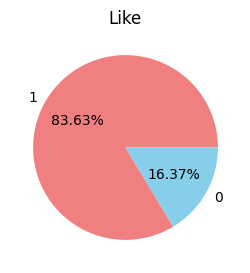

In [78]:
plt.figure(figsize=(3,3))
data['Like'].value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
plt.title('Like')
plt.ylabel( '' )
plt.show()

# LDA Grouping

### 1. Split every review to sentences.  

In [79]:
import re

def review_to_sentences(review):
    """
    split review into sentences contained by a list
    param: review (String)
    output: sentences (list of word)
    """
    sentences = review.splitlines()
    sentences = list(filter(None, sentences))
    tmp = []
    for sent in sentences:
        sent = re.split(r' *[\.\?!][\'"\)\]]* *', sent)
        tmp.extend(sent)
    # delete sentence less than specific number of words
    sentences = list(filter(lambda x:len(x.split())>=5, tmp))
    return sentences

In [80]:
list_split_sentences =  [review_to_sentences(review) for review in data["Review"]]
data["SplitReview"] = list_split_sentences
empty = [i for i, x in enumerate(data["SplitReview"]) if x ==[]] # Delete data whose splitReview is empty list
data.drop(empty, axis=0, inplace=True)
data.reset_index(drop=True, inplace=True)
data

,AppID,UserID,Like,Review,SplitReview,SplitReview_emb,LDA_group
0,945360,76561197977755278,0,[h1]Among Us[/h1]\n[u][i]I wish mixed reviews ...,"[[u][i]I wish mixed reviews were an option, Th...",,
1,945360,76561198123845513,1,[h1] [b] Sus [/b] [/h1]\n\nOverall Review: Red...,"[[h1] [b] Sus [/b] [/h1], Overall Review: Red ...",,
2,945360,76561198217183476,1,DON'T SAY IT DON'T SAY IT DON'T SAY IT.,[DON'T SAY IT DON'T SAY IT DON'T SAY IT],,
3,945360,76561198052712512,0,Imagine a social deduction game where there's ...,[Imagine a social deduction game where there's...,,
4,945360,76561199201016531,1,Everyone knows this one. Definitely recommend ...,"[Definitely recommend it, you'll get tons of fun]",,
...,...,...,...,...,...,...,...
21192,3020,76561198072006918,1,"A messy game. Lots of experiments, not all of ...","[Lots of experiments, not all of which went we...",,
21193,3020,76561197973200565,1,Not bad really. its pretty dated but not so mu...,"[its pretty dated but not so much really, as a...",,
21194,3020,76561197977451962,1,17 hours to beat.\ni played 2 first (bound in ...,[i played 2 first (bound in blood) so this is ...,,
21195,3020,76561198011647032,1,This game gave me times of raging because you ...,[This game gave me times of raging because you...,,


### 2. LDA Grouping
#### asign each given sentence a group

In [81]:
# Modify LDA part from 趙儀
def stemmer_with_delete_stopword(split_sentences):
    vectorizer = TfidfVectorizer(stop_words = "english")
    stop_list = list(vectorizer.get_stop_words())
    porter_stemmer = PorterStemmer()
    all_stem_sents=[]
    for review in split_sentences:
        review_stem_list = []
        for sent in review:
            sent_stem_list =[]
            for word in sent.split(" "):
                if len(word)>2:
                    if word not in stop_list:
                        sent_stem_list.append(porter_stemmer.stem(word))
            review_stem_list.append(sent_stem_list)
        all_stem_sents.append(review_stem_list) 
    return all_stem_sents

def LDAGrouping(reviews, groups):
    all_sents = []
    for review in reviews:
        for sentence in review:
            all_sents.append(sentence)
    dictionary = corpora.Dictionary(all_sents)
    corpus = [dictionary.doc2bow(sent) for sent in all_sents]
    lda_model = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=groups)
    group_results = []
    for sents in reviews:
        single_corpus = [dictionary.doc2bow(sent) for sent in sents]
        sents_group_result = []
        for scores in lda_model.inference(single_corpus)[0]:
            # scores.argmax()+1 --> Retain group:0 for no meaning sentences
            sents_group_result.append(scores.argmax()+1)
        group_results.append(sents_group_result)

    return group_results, lda_model

def pad_and_trunc(group_results, *, max_sentence):
    #max number of sentences in a review
    result_list = []
    for i, result in enumerate(group_results):
        if len(result) >= max_sentence:
            result = result[:10]
        else:
            result.extend([0]*(max_sentence-len(result)))
        result_list.append(np.array(result).astype(int))
    return result_list

In [82]:
clean_reviews = stemmer_with_delete_stopword(data["SplitReview"].tolist())
group_list, lda_model = LDAGrouping(clean_reviews, args["max_group"]) # Training might takes a little bit time 
pad_group_list = pad_and_trunc(group_list, max_sentence=args["max_sentence"])
data["LDA_group"] = pad_group_list
data

,AppID,UserID,Like,Review,SplitReview,SplitReview_emb,LDA_group
0,945360,76561197977755278,0,[h1]Among Us[/h1]\n[u][i]I wish mixed reviews ...,"[[u][i]I wish mixed reviews were an option, Th...",,"[1, 4, 4, 2, 5, 2, 4, 5, 3, 2]"
1,945360,76561198123845513,1,[h1] [b] Sus [/b] [/h1]\n\nOverall Review: Red...,"[[h1] [b] Sus [/b] [/h1], Overall Review: Red ...",,"[3, 3, 0, 0, 0, 0, 0, 0, 0, 0]"
2,945360,76561198217183476,1,DON'T SAY IT DON'T SAY IT DON'T SAY IT.,[DON'T SAY IT DON'T SAY IT DON'T SAY IT],,"[3, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,945360,76561198052712512,0,Imagine a social deduction game where there's ...,[Imagine a social deduction game where there's...,,"[5, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,945360,76561199201016531,1,Everyone knows this one. Definitely recommend ...,"[Definitely recommend it, you'll get tons of fun]",,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...
21192,3020,76561198072006918,1,"A messy game. Lots of experiments, not all of ...","[Lots of experiments, not all of which went we...",,"[5, 5, 4, 0, 0, 0, 0, 0, 0, 0]"
21193,3020,76561197973200565,1,Not bad really. its pretty dated but not so mu...,"[its pretty dated but not so much really, as a...",,"[4, 3, 3, 4, 2, 1, 0, 0, 0, 0]"
21194,3020,76561197977451962,1,17 hours to beat.\ni played 2 first (bound in ...,[i played 2 first (bound in blood) so this is ...,,"[4, 3, 1, 5, 0, 0, 0, 0, 0, 0]"
21195,3020,76561198011647032,1,This game gave me times of raging because you ...,[This game gave me times of raging because you...,,"[2, 2, 2, 4, 1, 4, 4, 5, 1, 0]"


In [83]:
# Print topics trained from LDA
for idx, topic in lda_model.show_topics(formatted=False, num_words= 30):
    print('Topic: {} \nWords: {}'.format(idx, '|'.join([w[0] for w in topic])))

Topic: 0 
Words: game|like|it'|the|stori|thi|quak|love|classic|great|shooter|good|duke|doom|call|charact|action|horror|just|titl|tomb|definit|fp|feel|raider|nukem|sequel|make|war|adventur
Topic: 1 
Words: the|level|use|enemi|you|weapon|time|just|make|shoot|charact|combat|design|kill|differ|way|fight|like|gun|control|nice|boss|run|mechan|feel|point|there|game|get|challeng
Topic: 2 
Words: don't|like|didn't|game|not|but|know|just|episod|rememb|want|thought|review|bad|peopl|did|what|expect|it'|you'll|matter|guy|play|origin|fall|damag|better|pace|you'v|human
Topic: 3 
Words: game|play|it'|the|good|realli|time|fun|stori|just|like|recommend|game,|thi|best|enjoy|worth|end|pretti|want|great|say|year|seri|look|graphic|long|hour|bad|old
Topic: 4 
Words: game|like|the|world|realli|good|feel|lot|area|thing|just|it'|open|dark|music|there|deu|make|look|collect|stori|game,|fix|age|origin|franchis|there'|need|new|limit


In [84]:
# Save the LDA grouping result
data.to_pickle(r"../data/filtered_review_group.pkl")

# Split Train Val Test

In [95]:
# Split train/val/test data by user case
train_df, val_df, test_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2
for app in set(data["AppID"]):
    single_user_data = data[data["AppID"]==app]
    single_user_data_train = single_user_data[:int(len(single_user_data)*train_ratio)]
    single_user_data_val = single_user_data[int(len(single_user_data)*train_ratio):int(len(single_user_data)*(train_ratio+val_ratio))]
    single_user_data_test = single_user_data[int(len(single_user_data)*(train_ratio+val_ratio)):]
    train_df = pd.concat([train_df, single_user_data_train], axis=0)
    val_df = pd.concat([val_df, single_user_data_val], axis=0)
    test_df = pd.concat([test_df, single_user_data_test], axis=0)
len(train_df), len(val_df), len(test_df), len(train_df)+len(val_df)+len(test_df)

(14739, 2100, 4358, 21197)

In [136]:
import random
from sklearn.model_selection import train_test_split

SEED = 21
random.seed(SEED)

train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

train_app = random.sample(set(data["AppID"]), int(len(set(data["AppID"]))*train_ratio))
test_app = list(set(data["AppID"])-set(train_app))
val_app = random.sample(test_app, int(len(set(data["AppID"]))*val_ratio))
test_app = list(set(test_app)-set(val_app))

train_mask = data["AppID"].isin(train_app)
train_df = data[train_mask]

val_mask = data["AppID"].isin(val_app)
val_df = data[val_mask]

test_mask = data["AppID"].isin(test_app)
test_df = data[test_mask]



print(len(set(data["AppID"])))
print(len(train_app), len(val_app), len(test_app))
print(len(data), len(train_df)+len(val_df)+len(test_df), len(train_df), len(val_df), len(test_df))

213
149 21 43
21197 21197 14877 1916 4404


In [140]:
print("Train: ", len(train_df["UserID"].unique()), len(train_df["AppID"].unique())) 
print("Val: ", len(val_df["UserID"].unique()), len(val_df["AppID"].unique())) 
print("Test: ", len(test_df["UserID"].unique()), len(test_df["AppID"].unique())) 

Train:  718 149


In [96]:
# Exchange negative samples in testing with positive samples in training (劉老大要求test的label都要是1)
n_samples = len(test_df[test_df["Like"]==0])
n_sample_test = test_df[test_df["Like"]==0]
p_sample_train = train_df[train_df["Like"]==1].sample(n_samples)
test_df.drop(index=n_sample_test.index, inplace=True)
train_df.drop(index=p_sample_train.index, inplace=True)
test_df = pd.concat([test_df, p_sample_train])
train_df = pd.concat([train_df, n_sample_test])

print(len(n_sample_test))
print(len(train_df))
print(len(test_df))

552
14739
4358


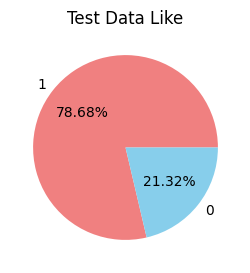

In [97]:
plt.figure(figsize=(3,3))
train_df['Like'].value_counts().plot( kind='pie', colors=['lightcoral','skyblue'], autopct='%1.2f%%' )
plt.title('Test Data Like')
plt.ylabel( '' )
plt.show()

### Adding negitive samples to Testing data 

In [88]:
# Build the false samples of testing
test_false_df = pd.DataFrame(columns=["AppID", "UserID", "Like"])
app_list = []
user_list = []
like_list = []
all_app = set(test_df["AppID"])
for user in set(test_df["UserID"]):
    user_have_item = list(test_df[test_df["UserID"]==user]["AppID"])
    for item in all_app:
        if (item in user_have_item) or (not train_df[(train_df["UserID"]==user) & (train_df["AppID"]==item)].empty) or (not val_df[(val_df["UserID"]==user) & (val_df["AppID"]==item)].empty):
            continue
        else:
            app_list.append(item)
            user_list.append(user)
            like_list.append(0)
test_false_df["AppID"] = app_list
test_false_df["UserID"] = user_list
test_false_df["Like"] = like_list
test_false_df

,AppID,UserID,Like
0,17410,76561198025398275,0
1,264710,76561198025398275,0
2,264200,76561198025398275,0
3,1145360,76561198025398275,0
4,612880,76561198025398275,0
...,...,...,...
128971,360430,76561199081818109,0
128972,500,76561199081818109,0
128973,782330,76561199081818109,0
128974,8140,76561199081818109,0


In [89]:
# Concat true and false sample into new test dataset
test_df = pd.concat([test_df, test_false_df])
test_df = shuffle(test_df)
test_df.reset_index(drop=True, inplace=True)
test_df

,AppID,UserID,Like,Review,SplitReview,SplitReview_emb,LDA_group
0,6900,76561198068581349,0,NaN,NaN,NaN,NaN
1,2270,76561197982628667,0,NaN,NaN,NaN,NaN
2,501300,76561198028175158,0,NaN,NaN,NaN,NaN
3,57900,76561198040340684,0,NaN,NaN,NaN,NaN
4,237630,76561197999938574,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
133649,976730,76561197986992213,0,NaN,NaN,NaN,NaN
133650,4500,76561198015074622,0,NaN,NaN,NaN,NaN
133651,211600,76561197960812852,0,NaN,NaN,NaN,NaN
133652,16450,76561198186530370,0,NaN,NaN,NaN,NaN


In [90]:
# Saving three types of dataframe
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_df.to_pickle(r"../data/train_df.pkl")
val_df.to_pickle(r"../data/val_df.pkl")
test_df.to_pickle(r"../data/test_df.pkl")

# Bert Encode

### 1. Init Bert and encode methods

In [91]:
def padding_to_tagert_dimension(input_tensor, sent_len, word_len, word_dim):
    """
    Set input_tensor to specified dim with zero padding, and flatten it
    ex: [3, 25, 768] -> [10, 25, 768] -> [250, 768]
    """
    target_emb = torch.zeros(sent_len, word_len, word_dim)
    target_emb[:input_tensor.size(dim=0), :, :] = input_tensor
    target_emb = torch.flatten(target_emb, start_dim=0, end_dim=1)
    
    return target_emb

def bert_encode(review_split, args):
    """
    Encode splitted review to bert embedding
    return embedding of review padded with zero
    """
    emb_list = []
    for i, sentence in enumerate(review_split):
        if i == args["max_sentence"]: break
        sentence_encode = args["bert_tokenizer"](
            sentence,
            return_attention_mask = True,
            max_length = args["max_word"],
            truncation = True,
            padding = "max_length",
            return_tensors = 'pt'
            )
        for k,v in sentence_encode.items():
            sentence_encode[k] = v.to(args["device"])
        with torch.no_grad():
            outputs = args["bert_model"](**sentence_encode)
        sentence_emb = outputs[2][-1]
        emb_list.append(sentence_emb)
    review_emb = torch.cat(emb_list, 0)
    pad_review_emb = padding_to_tagert_dimension(review_emb, args["max_sentence"], args["max_word"], args["emb_dim"])
    return pad_review_emb

### 2. Encode splited sentences and save into multiple chunks of H5DF

In [92]:
# Saving emb for each "user"
def save_each_bert_emb(data, *, col_name, target, max_review):
    user_set_len = len(set(data[col_name]))
    for i, indie in enumerate(set(data[col_name])):
        print("執行%s進度: %d/%d\r"%(target, i+1, user_set_len), end="")
        user_data = data[data[col_name]==indie]
        for index, review in zip(user_data.index, user_data["SplitReview"]):
            review_emb = np.asarray(bert_encode(review, args))
            user_data.at[index, "SplitReview_emb"] = review_emb
            user_data[["SplitReview_emb", "LDA_group", "Like"]][:max_review].to_pickle(f'../data/{target}_emb/{indie}.pkl')

In [102]:
# This step require a lot of disk storage. Please make sure that you have sufficient space.
save_each_bert_emb(data, col_name="UserID", target="user", max_review=args["max_review_user"])

In [103]:
# This step require a lot of disk storage. Please make sure that you have sufficient space.
# Can't store all emb into one df, so it has to be run twice 
save_each_bert_emb(data, col_name="AppID", target="item", max_review=args["max_review_item"])

### 3. Show Bert Encode Result

In [51]:
tmp = pd.read_pickle(r"../data/item_emb/50620.pkl")
torch.from_numpy(np.array(tmp["SplitReview_emb"].tolist())).size()

torch.Size([50, 250, 768])

In [52]:
tmp = pd.read_pickle(r"../data/user_emb/76561197976257774.pkl")
torch.from_numpy(np.array(tmp["SplitReview_emb"].tolist())).size()

torch.Size([20, 250, 768])

# Matrix Factorization

In [104]:
mf_df = pd.read_pickle(r"../data/filtered_review_group.pkl")
mf_df = mf_df[['AppID', 'UserID', 'Like']]
mf_df['Interacted'] = 1
mf_df

,AppID,UserID,Like,Interacted
0,945360,76561197977755278,0,1
1,945360,76561198123845513,1,1
2,945360,76561198217183476,1,1
3,945360,76561198052712512,0,1
4,945360,76561199201016531,1,1
...,...,...,...,...
21442,3020,76561198072006918,1,1
21443,3020,76561197973200565,1,1
21444,3020,76561197977451962,1,1
21445,3020,76561198011647032,1,1


In [105]:
# Modify MF From 裴伯儀
def train_test_random_split(df):
    app_ids = list(df.columns)
    user_ids = list(df.index)
    user_set = {}
    for user_id in user_ids:
        interacted_items = [app_ids[idx] for idx in df.loc[user_id].values.nonzero()[0].tolist()]
        user_set[user_id] = interacted_items
    return user_set

def get_trainVector(df, user_set):
    business_ids = list(df.columns)
    user_ids = list(df.index)
    return [ [1 if business_id in user_set[user_id] else 0 for business_id in business_ids ] for user_id in user_ids]

def matrix_factorization(matrix, trainVector):
    # n_components is embedding dimension, vervose=1 shows the training process
    model = NMF(n_components=128, init='random', random_state=0, verbose=0)
    user_embeddings = model.fit_transform(trainVector*matrix.values)
    encoded_user_embeddings = np.asarray(user_embeddings, dtype=np.float32)
    app_embeddings = model.components_.T
    encoded_app_embeddings = np.asarray(app_embeddings.astype('float32'))
    user_id_emb = dict(zip(matrix.index, encoded_user_embeddings))
    app_id_emb = dict(zip(matrix.columns, encoded_app_embeddings))
    
    return user_id_emb, app_id_emb

### Construct Rating Matrix and Interaction Matrix

In [106]:
interaction_matrix = mf_df.pivot_table(index='UserID', columns='AppID', values='Interacted').fillna(0)
rating_matrix = mf_df.pivot_table(index='UserID', columns='AppID', values='Like').fillna(0)
user_set = train_test_random_split(interaction_matrix)
trainVector = torch.tensor(get_trainVector(interaction_matrix, user_set)).to(torch.float32)

### Train MF Model

In [107]:
user_id_emb, app_id_emb = matrix_factorization(rating_matrix, trainVector)
len(user_id_emb), len(app_id_emb), next(iter(user_id_emb.values())).shape, next(iter(app_id_emb.values())).shape

(724, 213, (128,), (128,))

### Save MF Embedding

In [108]:
app_mf_df = pd.DataFrame()
app_mf_df["AppID"] = list(app_id_emb.keys())
app_mf_df["MF_emb"] = list(app_id_emb.values())
app_mf_df.to_pickle(r"../data/train_item_mf_emb.pkl")

user_mf_df = pd.DataFrame()
user_mf_df["UserID"] = list(user_id_emb.keys())
user_mf_df["MF_emb"] = list(user_id_emb.values())
user_mf_df.to_pickle(r"../data/train_user_mf_emb.pkl")

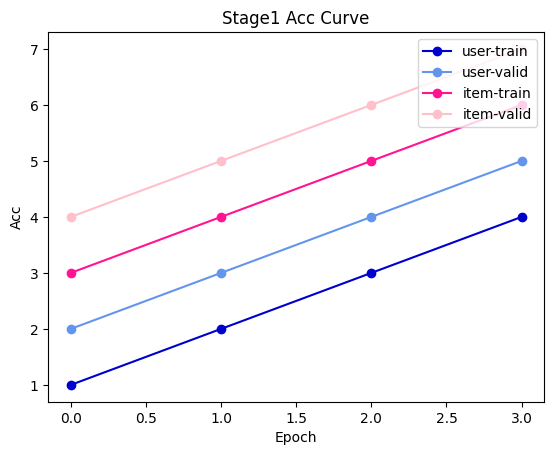

In [59]:
import matplotlib.pyplot as plt

t1 = [1,2,3,4]
v1 = [2,3,4,5]
t2 = [3,4,5,6]
v2 = [4,5,6,7]

# Plot test
def draw_acc_curve_stage1(u_train_acc, u_valid_acc, i_train_acc, i_valid_acc):
    plt.plot(u_train_acc, color="mediumblue", label="user-train", marker='o')
    plt.plot(u_valid_acc, color="cornflowerblue", label="user-valid", marker='o')
    plt.plot(i_train_acc, color="deeppink", label="item-train", marker='o')
    plt.plot(i_valid_acc, color="pink", label="item-valid", marker='o')
    plt.legend(loc="upper right")
    plt.xlabel("Epoch")
    plt.ylabel("Acc")
    plt.title(f"Stage1 Acc Curve")
    # plt.savefig('output/plot/collab/acc_stage1_{}.png'.format(time.strftime("%m%d%H%M%S")))
    plt.show()

draw_acc_curve_stage1(t1,v1, t2, v2)

In [72]:
tmp = pd.read_pickle(r'../data/reviews_21447.pkl')
for user in set(tmp["UserID"]):
    user_df = tmp[tmp["UserID"]==user]
    if len(user_df[user_df["Like"]==0])/len(user_df) >= 0.7:
        print(user, len(user_df[user_df["Like"]==0]), len(user_df)) 

76561197960282358 20 28
76561197986406741 22 26
76561198385097639 32 33
76561197994372073 32 32
76561198027267313 50 59
76561198101732759 54 72


In [22]:
review_df = pd.read_pickle("../data/test_df.pkl")

def get_empty_incidence_df():
    user_index = set(review_df["UserID"])
    app_index = set(review_df["AppID"])
    incidence_df = pd.DataFrame(index=set(user_index), columns=set(app_index), dtype=np.float32)
    incidence_df.fillna(0, inplace=True)
    incidence_df.sort_index(inplace=True)
    incidence_df = incidence_df.reindex(sorted(incidence_df.columns), axis=1)
    return incidence_df

def get_true_incidence_df():
    user_index = set(review_df["UserID"])
    incidence_df = get_empty_incidence_df()
    for user in user_index:
        user_df = review_df[review_df["UserID"]==user]
        user_like_app_list = list(user_df[user_df["Like"]==1]["AppID"])
        incidence_df.at[user, user_like_app_list] = 1
    return incidence_df

label_incidence_df = get_true_incidence_df()
label_incidence_df

,320,400,420,500,550,620,2100,2200,2210,2270,...,1092790,1097150,1145360,1148590,1172380,1174180,1233570,1237970,1245620,1794680
76561197960282358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561197960425408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561197960440071,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561197960458021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561197960478145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76561199024836865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561199057481492,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561199067595529,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76561199081818109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score, ndcg_score, average_precision_score
import math

def ndcg(y_true, y_pred, top_K=0):
    # From 趙儀
    ndcg_K = []
    true_sum = 0

    for i in range(y_pred.shape[0]):
        top_indices = y_pred[i].argsort()[-top_K:][::-1] #每篇文章排名前Top K可能的tag index
        true_num = np.sum(y_true[i, :])
        true_sum += true_num
        dcg = 0
        idcg = 0
        idcgCount = true_num
        j = 0
        for item in top_indices:
            if y_true[i, item] == 1:
                dcg += 1.0/math.log2(j + 2)
            if idcgCount > 0:
                idcg += 1.0/math.log2(j + 2)
                idcgCount = idcgCount-1
            j += 1
        if(idcg != 0):
            ndcg_K.append(dcg/idcg)

    return  np.mean(np.array(ndcg_K))

TOP_N = 10
predict_incidence_df = pd.read_pickle('output/history/probability_df.pkl')
top_k_df = pd.read_pickle('output/history/topk_prediction_df.pkl')

global_hit_10 = 0
global_hit_5 = 0
global_like = 0

global_labels = []
global_prediction = []

# Calculate each score
for user in predict_incidence_df.index:
    
    # Data for scoring
    user_topk_prediction = top_k_df.loc[user]
    user_pred_prob = predict_incidence_df.loc[user]
    
    user_label = label_incidence_df.loc[user]
    user_like = user_label[user_label==1].keys()
    user_topk_label = label_incidence_df.loc[user, user_topk_prediction]

    # get 01 prediction from probability
    pred_tensor = torch.tensor(user_pred_prob.values)
    value, idx = pred_tensor.topk(k=TOP_N)
    user_pred_binary = torch.zeros(pred_tensor.size())
    user_pred_binary[idx] = 1 

    global_like += len(user_like)
    global_labels.append(user_label.tolist())
    global_prediction.append(user_pred_binary.tolist())

    # Top-10 hit ratio
    user_top_10_label = user_topk_label[:10]
    global_hit_10 += len(user_top_10_label[user_top_10_label==1])

    # Top-5 hit ratio
    user_top_5_label = user_topk_label[:5]
    global_hit_5 += len(user_top_5_label[user_top_5_label==1])

test_precision = precision_score(global_labels, global_prediction, zero_division=0, average="macro")
test_recall = recall_score(global_labels, global_prediction, zero_division=0, average="macro")
test_f1 = f1_score(global_labels, global_prediction, zero_division=0, average="macro")

test_top_10_hr = global_hit_10 / global_like
test_top_5_hr = global_hit_5 / global_like

test_map = average_precision_score(label_incidence_df.to_numpy(), predict_incidence_df.to_numpy())
test_ndcg = ndcg(label_incidence_df.to_numpy(), predict_incidence_df.to_numpy(), TOP_N)

print(f"[ Test base ] precision@{TOP_N} = {test_precision:.4f}, recall@{TOP_N} = {test_recall:.4f}, f1@{TOP_N} = {test_f1:.4f}")
print(f"[ Test base ] MAP@{TOP_N} = {test_map:.4f}, NDCG@{TOP_N} = {test_ndcg:.4f}, HR@10 = {test_top_10_hr:.4f}, HR@5 = {test_top_5_hr:.4f}")

[ Test base ] precision@10 = 0.0035, recall@10 = 0.0675, f1@10 = 0.0058
[ Test base ] MAP@10 = 0.0658, NDCG@10 = 0.0248, HR@10 = 0.0321, HR@5 = 0.0126


In [54]:
for user in predict_incidence_df.index:
    user_pred_prob = predict_incidence_df.loc[user]
    user_label = label_incidence_df.loc[user]

    pred_tensor = torch.tensor(user_pred_prob.values)
    value, idx = pred_tensor.topk(k=TOP_N)
    user_pred_binary = torch.zeros(pred_tensor.size())
    user_pred_binary[idx] = 1 

    print(user_label.tolist())

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,